### Claude3 Opus/Sonnet/Haikuでの画像読み取り

In [1]:
import time
import anthropic
import base64
from itertools import product

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from PIL import Image
import anthropic
import japanize_matplotlib
import pandas as pd
import seaborn as sns

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

from PIL import Image

pd.set_option('display.max_colwidth', 5000)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
client = anthropic.Anthropic(api_key="your_api_key")

In [2]:
models = [
    "claude-3-opus-20240229",
    "claude-3-sonnet-20240229",
    "claude-3-haiku-20240307",
]
model_cost = {
    "claude-3-opus-20240229":  {
        'input_tokens'  : 15 / 1_000_000,
        'output_tokens' : 75 / 1_000_000,
    },
    "claude-3-sonnet-20240229": {
        'input_tokens'  : 3 / 1_000_000,
        'output_tokens' : 15 / 1_000_000,
    },
    "claude-3-haiku-20240307": {
        'input_tokens'  : 0.25 / 1_000_000,
        'output_tokens' : 1.25 / 1_000_000,
    },
}

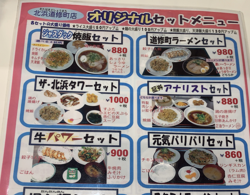

In [3]:
image_paths = [
    './img/osho_menu.jpg',
    './img/osho_menu_lite.jpg',
]

im = Image.open('./img/osho_menu.jpg')
im.thumbnail((250, 250))
im

In [4]:
question_prefix = '画像を参照して、以下の質問に回答してください。\n回答は順序立ててステップごとに出力してください。\nQ:'
question_suffix = '\nA:'
questions = [
    'ザ・北浜タワーセットの価格を教えてください。',
    '牛パワーセットのライスを大盛りにしたときの価格を教えて下さい。',
    '餃子とみそ汁が食べられるメニューを教えてください。', 
    '私はダイエット中の30代男性です。ランチにおすすめのメニューはどれですか？'
]

In [5]:
records = []
for model, question, image_path in product(models, questions, image_paths):
    start_time = time.time()
    message = client.messages.create(
        model=model,
        max_tokens=1024,
        temperature=0.,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": encode_image(image_path),
                        },
                    },
                    {
                        "type": "text",
                        "text": question_prefix + question + question_suffix
                    }
                ],
            }
        ],
    )
    end_time = time.time()
    execution_time = end_time - start_time

    if execution_time < 12:
        # ratelimit対策(無課金ユーザーは1分5リクエストまで)
        # https://docs.anthropic.com/claude/reference/rate-limits#rate-limits
        time.sleep(13 - execution_time)

    image_size = Image.open(image_path).size
    record = {
        "model": model,
        "image_path" : image_path,
        "image_size" : f'{image_size[0]:.0f}x{image_size[1]:.0f}',
        "question_no" : questions.index(question) + 1,
        "question": question,
        "answer": message.content[0].text,
        "input_tokens" : message.usage.input_tokens,
        "output_tokens": message.usage.output_tokens,
        "input_cost": message.usage.input_tokens * model_cost[model]['input_tokens'],
        "output_cost": message.usage.output_tokens * model_cost[model]['output_tokens'],
        "execution_time": execution_time,
    }
    records.append(record)

In [6]:
#pandasの出力文字数を増やす”
result_df = pd.DataFrame(records)
result_df.to_csv('result.csv', index=False)

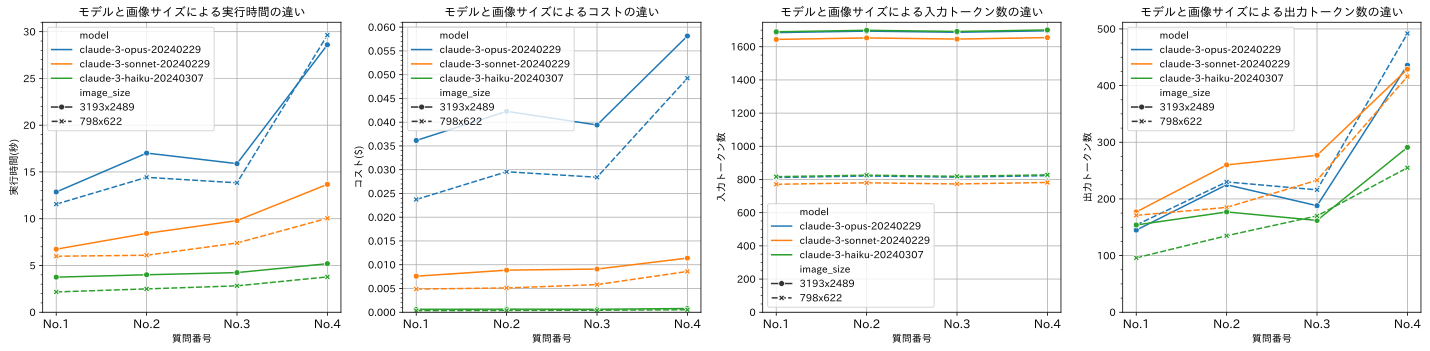

In [5]:
result_df = (
    pd.read_csv('result.csv')
    .assign(question_no = lambda x: 'No.' + x.question_no.astype(str))
    .assign(total_cost=lambda x: x.input_cost + x.output_cost)
)

fig, axs = plt.subplots(1,4,figsize=(20, 5))

ax = axs.flatten()[0]
ax.xaxis.set_label_text("質問番号")
ax.yaxis.set_label_text("実行時間(秒)")
ax.set_title("モデルと画像サイズによる実行時間の違い")
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
sns.lineplot(ax=ax, data = result_df, x="question_no", y="execution_time", hue="model", style="image_size",markers=True)


ax =  axs.flatten()[1]
ax.xaxis.set_label_text("質問番号")
ax.yaxis.set_label_text("コスト($)")
ax.set_title("モデルと画像サイズによるコストの違い")
sns.lineplot(ax=ax, data = result_df, x="question_no", y="total_cost", hue="model", style="image_size",markers=True)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.001))


ax =  axs.flatten()[2]
ax.xaxis.set_label_text("質問番号")
ax.yaxis.set_label_text("入力トークン数")
ax.set_title("モデルと画像サイズによる入力トークン数の違い")
sns.lineplot(ax=ax, data = result_df, x="question_no", y="input_tokens", hue="model", style="image_size",markers=True)
ax.yaxis.set_major_locator(plt.MultipleLocator(200))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))


ax =  axs.flatten()[3]
ax.xaxis.set_label_text("質問番号")
ax.yaxis.set_label_text("出力トークン数")
ax.set_title("モデルと画像サイズによる出力トークン数の違い")
sns.lineplot(ax=ax, data = result_df, x="question_no", y="output_tokens", hue="model", style="image_size",markers=True)
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_minor_locator(plt.MultipleLocator(25))

for ax in axs.flatten():
    ax.xaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_label_text("質問番号")
    ax.set_ylim(0,)
    ax.grid()

plt.tight_layout()
plt.show()